# Predição do alfabeto de sinais

## Libs utilizadas no desenvolvimento

In [1]:
import csv
import string
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Leitura e Modelagem dos Dados

In [2]:
def get_data(filename):
    with open(filename) as training_file:
        training_reader = csv.reader(training_file, delimiter=',')
        image = []
        labels = []
        line_count = 0
        for row in training_reader:
            if line_count == 0:
                line_count +=1
            else:
                labels.append(row[0])
                temp_image = row[1:785]
                image_data_as_array = np.array_split(temp_image, 28)
                image.append(image_data_as_array)
                line_count += 1
        images = np.array(image).astype('float')
        labels = np.array(labels).astype('float')
        print(f'Processed {line_count} lines.')

    return images, labels

In [3]:
train_imgs, train_labels = get_data("../datasets/sign_mnist_train.csv")
test_imgs, test_labels = get_data("../datasets/sign_mnist_test.csv")

print("Total Training images", train_imgs.shape)
print("Total Training labels",train_labels.shape)
print("Total Testing images",test_imgs.shape)
print("Total Testing labels",test_labels.shape)

Processed 27456 lines.
Processed 7173 lines.
Total Training images (27455, 28, 28)
Total Training labels (27455,)
Total Testing images (7172, 28, 28)
Total Testing labels (7172,)


In [4]:
# Mapeamento das letras do alfabeto de acordo com a posição dela
alphabets = string.ascii_lowercase
map_letter =  {}

for i, letter in enumerate(alphabets):
    map_letter[letter] = i
map_letter = {v:k for k, v in map_letter.items()}

train_labels = pd.Series(train_labels).map(map_letter)
test_labels = pd.Series(test_labels).map(map_letter)

## Vizualização Geral dos Dados

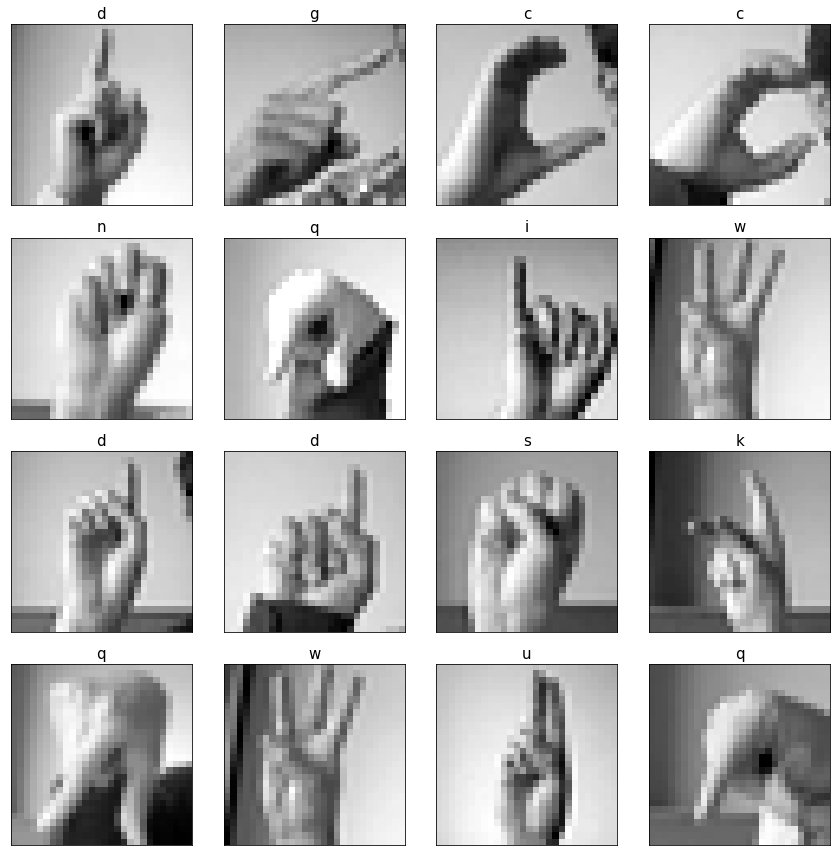

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = train_imgs[i].reshape(28,28)
    ax.imshow(img, cmap='gray')
    title = train_labels[i]
    ax.set_title(title, fontsize=15)
plt.tight_layout()
plt.show()

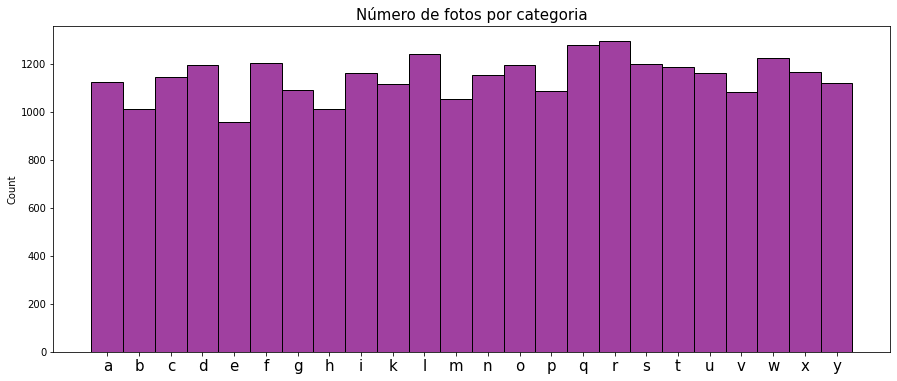

In [6]:
plt.figure(figsize=(15,6))
sns.histplot(sorted(train_labels), color='purple')
plt.title("Número de fotos por categoria", fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## Data Augmentation

In [7]:
train_imgs_s = np.expand_dims(train_imgs, axis=3)
test_imgs_s = np.expand_dims(test_imgs, axis=3)

print(train_imgs_s.shape)
print(test_imgs_s.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   zoom_range=0.1,
                                   shear_range=0.1,
                                   rotation_range=10,
                                   fill_mode='nearest',
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_datagenerator = train_datagen.flow(train_imgs_s, train_labels, batch_size=32)

validation_datagenerator = validation_datagen.flow(test_imgs_s, test_labels, batch_size=32)

## Definição de um Callback personalizado

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.99):
            print("\nCancelando treinamento devido a acurácia de 99%!")
            self.model.stop_training = True

## Construção do Modelo

In [10]:
model = keras.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(25, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 512)         590336    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                            patience = 2, 
                                                            verbose=1,factor=0.25, 
                                                            min_lr=0.0001)

callbacks = myCallback()

history = model.fit(train_datagenerator,
                    validation_data = validation_datagenerator,
                    steps_per_epoch = len(train_labels)//32,
                    epochs = 100,
                    validation_steps = len(test_labels)//32,
                    callbacks = [callbacks, learning_rate_reduction])

Epoch 1/100
857/857 [==============================] - 53s 61ms/step - loss: 1.8840 - accuracy: 0.3762 - val_loss: 0.8158 - val_accuracy: 0.7026
Epoch 2/100
857/857 [==============================] - 52s 60ms/step - loss: 0.6270 - accuracy: 0.7787 - val_loss: 0.3157 - val_accuracy: 0.8747
Epoch 3/100
857/857 [==============================] - 52s 61ms/step - loss: 0.3337 - accuracy: 0.8831 - val_loss: 0.2050 - val_accuracy: 0.9279
Epoch 4/100
857/857 [==============================] - 53s 62ms/step - loss: 0.2148 - accuracy: 0.9266 - val_loss: 0.1119 - val_accuracy: 0.9679
Epoch 5/100
857/857 [==============================] - 51s 60ms/step - loss: 0.1657 - accuracy: 0.9437 - val_loss: 0.0827 - val_accuracy: 0.9720
Epoch 6/100
857/857 [==============================] - 54s 63ms/step - loss: 0.1263 - accuracy: 0.9584 - val_loss: 0.0555 - val_accuracy: 0.9820
Epoch 7/100
857/857 [==============================] - 52s 61ms/step - loss: 0.1167 - accuracy: 0.9614 - val_loss: 0.0733 - val_ac

In [14]:
model_json = model.to_json()
with open('../models/model.json', 'w') as json_file:
    json_file.write(model_json)